In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import itertools
from os import path
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 13]
pd.options.display.width = 500
n_bins_default = 15

In [3]:
def load_cache(file_path):
    with open(path.expanduser(file_path), 'rb') as f:
        cache_dict = pickle.load(f)
        df = cache_dict['df']
        p = list(cache_dict['parameter_names'])
        return df, p

In [4]:
class ModelPlot:
    def __init__(self, x, y, d, label, color, linewidth=3, linestyle=None):
        self.label = label
        self.color = color
        self.linewidth = linewidth
        self.linestyle = linestyle
        self.x = x
        self.y = y
        self.d = d

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

def plot_model(model_plot_list, n_bins, ax=None, percentiles=None):
    p = ax if ax is not None else plt
    for model_plot in model_plot_list:
        d_grouped_by_gs = model_plot.d.groupby(pd.cut(model_plot.d[model_plot.x.name], n_bins))
        d_grouped_by_gs_agg = d_grouped_by_gs.agg([np.mean, percentile(25), percentile(75), percentile(95)])
        
        p.plot(
            d_grouped_by_gs_agg[model_plot.x.name]['mean'],
            d_grouped_by_gs_agg[model_plot.y.name]['mean'],
            label=model_plot.label,
            color=model_plot.color,
            linewidth=model_plot.linewidth,
            linestyle=model_plot.linestyle,
        )
        if percentiles and 25 in percentiles:
            p.plot(
                d_grouped_by_gs_agg[model_plot.x.name]['mean'],
                d_grouped_by_gs_agg[model_plot.y.name]['percentile_25'],
                label=model_plot.label + ' percentile_25',
                color=model_plot.color,
                linestyle=':',
                linewidth=model_plot.linewidth/2,
            )
        if percentiles and 75 in percentiles:
            p.plot(
                d_grouped_by_gs_agg[model_plot.x.name]['mean'],
                d_grouped_by_gs_agg[model_plot.y.name]['percentile_75'],
                label=model_plot.label + ' percentile_75',
                color=model_plot.color,
                linestyle='-.',
                linewidth=model_plot.linewidth/2,
            )
        if percentiles and 95 in percentiles:
            p.plot(
                d_grouped_by_gs_agg[model_plot.x.name]['mean'],
                d_grouped_by_gs_agg[model_plot.y.name]['percentile_95'],
                label=model_plot.label + ' percentile_95',
                color=model_plot.color,
                linestyle='--',
                linewidth=model_plot.linewidth/2,
            )
        
        if ax is not None:
            ax.set(xlabel=model_plot.x.name, ylabel=model_plot.y.name)
        else:
            plt.xlabel(model_plot.x.name)
            plt.ylabel(model_plot.y.name)

In [5]:
rename_dict = {
    'relative_localization_error_translation_mean': 'translation_error',
    'geometric_similarity_sensor_mean_of_translation_eigenvalues_ratio_all': 'tgs',
    'lidar_visibility_mean_visible_ranges_ratio': 'lvr',
    'waypoint_start_time': 'start_time',
}
p = [
    'laser_scan_max_range',
    'laser_scan_fov_deg',
    'beta',
    'environment_name',
    'linear_update',
    'slam_node',
]
m = [
    'start_time',
    'translation_error',
    'tgs',
    'lvr',
]
df, params = load_cache("/home/enrico/ds/performance_modelling/output/slam_new_config/run_data_per_waypoint_cache.pkl")
df.rename(columns=rename_dict, inplace=True)
df['linear_update'] = df['linear_angular_update'].apply(lambda x: x[0])
df = df[p+m]

for c in p:
    print("{:>30}".format(c), sorted(list(df[c].unique())))

          laser_scan_max_range [3.5, 8.0, 30.0]
            laser_scan_fov_deg [90, 180, 359]
                          beta [(0.0, 0.0, 0.0, 0.0), (2.0, 0.0, 2.0, 0.0)]
              environment_name ['7A-2', 'airlab', 'fr079', 'office_b']
                 linear_update [0.2, 0.5]
                     slam_node ['gmapping', 'slam_toolbox']


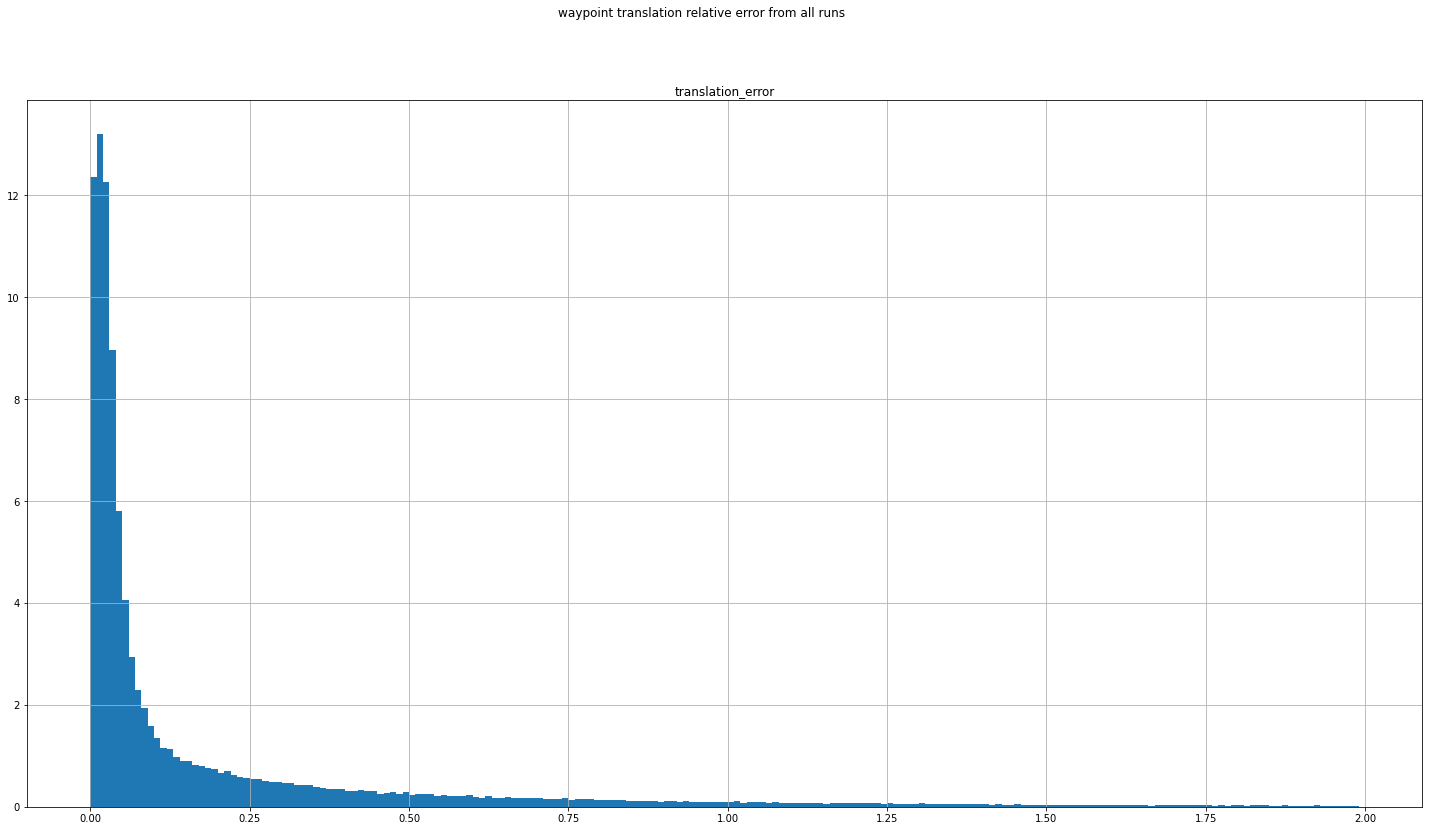

In [6]:
x = np.arange(0, 2, 0.01)
plt.hist(df.translation_error, bins=x, density=True)

plt.title("translation_error")
plt.grid(True)
plt.suptitle("waypoint translation relative error from all runs")
plt.show()

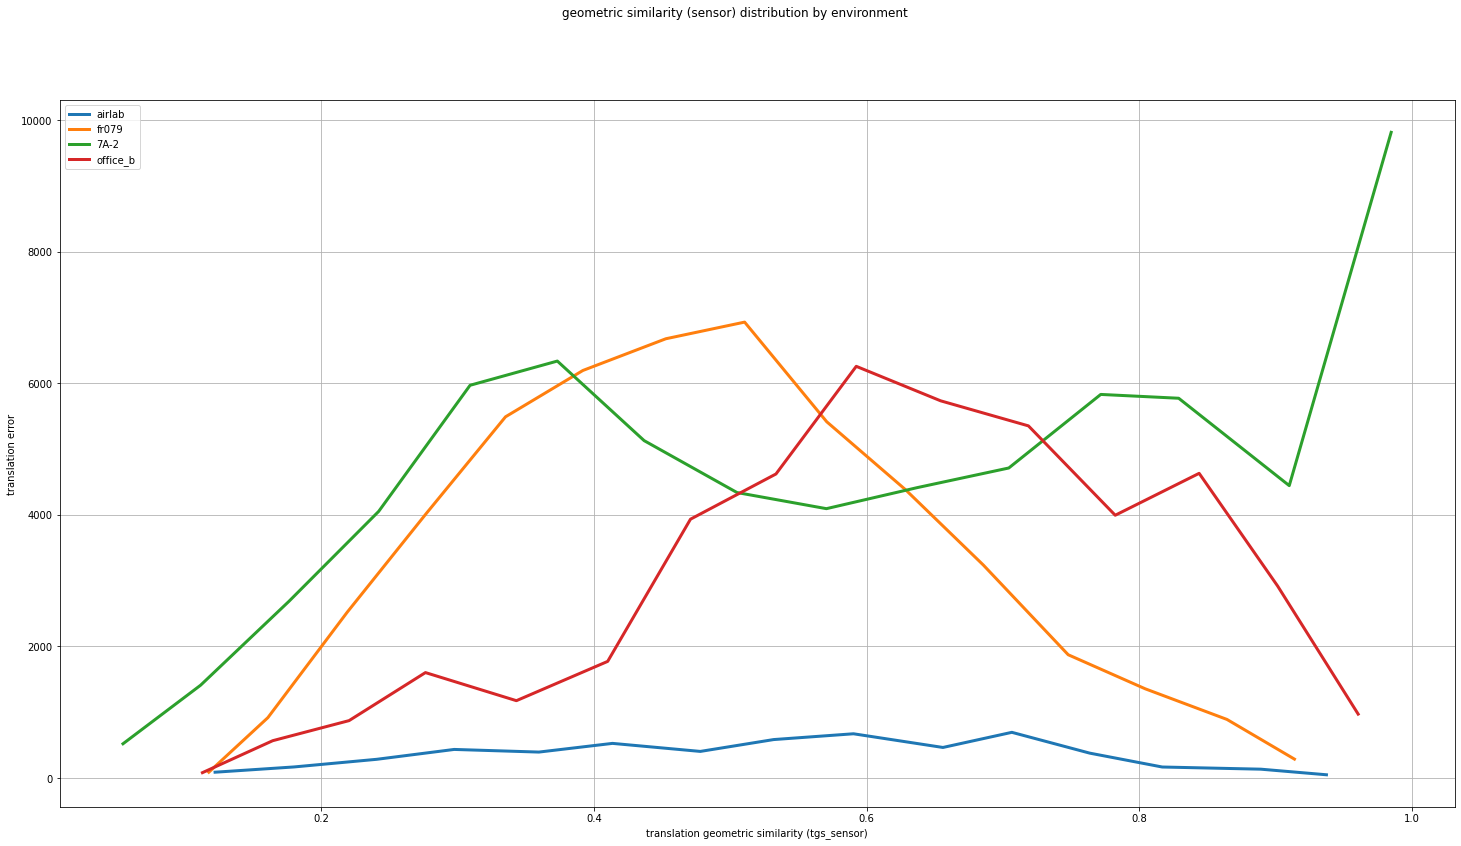

In [7]:
plt.xlabel('translation geometric similarity (tgs_sensor)') 
plt.ylabel('translation error')

for env_name in df.environment_name.unique():
    df_by_env = df[df.environment_name == env_name]
    df_by_env_bined = df_by_env.groupby(pd.cut(df_by_env.tgs, n_bins_default))
    df_hist = df_by_env_bined.agg(['mean', 'count'])
    plt.plot(
        df_hist[('tgs', 'mean')], 
        df_hist[('tgs', 'count')], 
        label=env_name, 
        linewidth=3)
plt.legend()
plt.grid(True)

plt.suptitle("geometric similarity (sensor) distribution by environment")
plt.show()

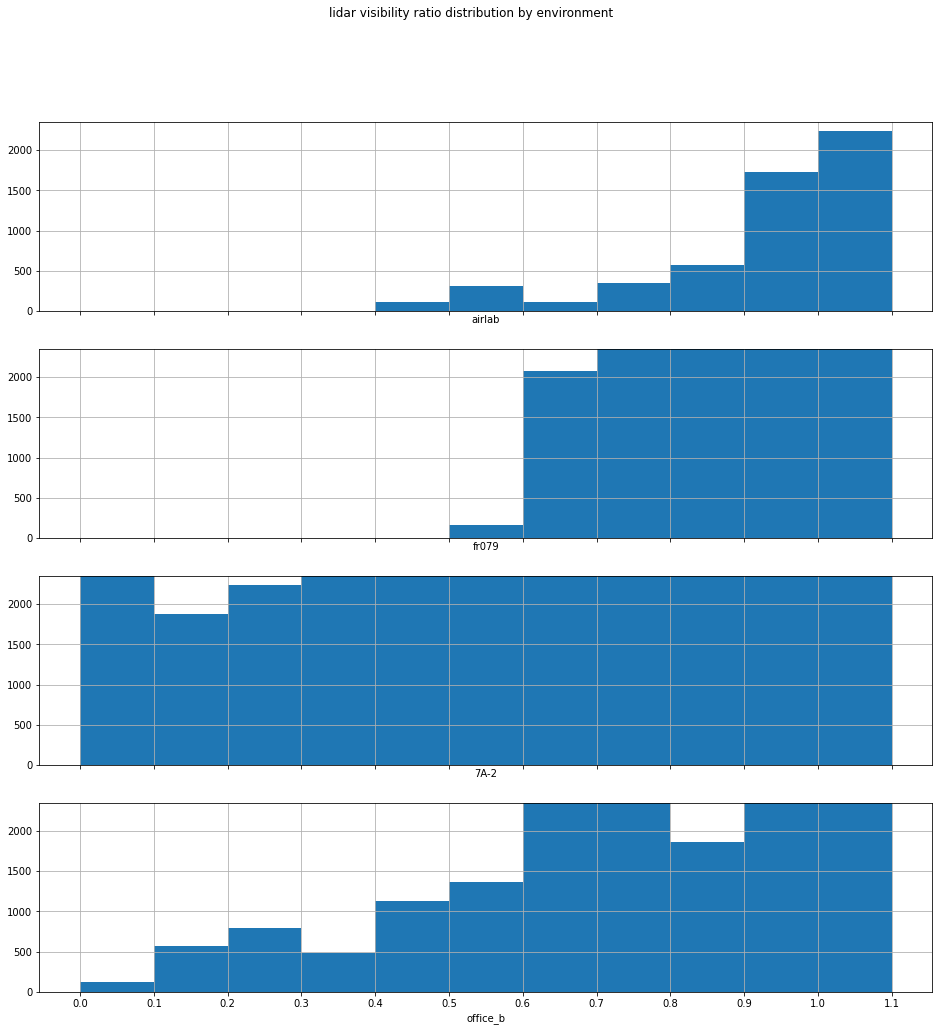

In [8]:
bins = list(np.arange(0.0, 1.2, 0.1))
env_names = df.environment_name.unique()

fig, axs = plt.subplots(len(env_names))
for ax in axs.flat:
    ax.label_outer()

for env_name, ax in zip(env_names, axs):
    df_by_env = df[df.environment_name == env_name]
    ax.hist(df_by_env.lvr, bins=bins)
    ax.set(xlabel=env_name, xticks=bins)
    ax.sharex(axs[0])
    ax.sharey(axs[0])
    ax.grid(True)

fig.set_size_inches([16, 16])
plt.suptitle("lidar visibility ratio distribution by environment")
plt.show()